# Run Mask-RCNN inception v2 model under onnxruntime 
comment

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
from object_detection.utils import label_map_util
import matplotlib.pyplot as plt
import glob
import time
import json

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image, ImageDraw, ImageColor

import onnxruntime as rt

In [2]:
# change working directory
ROOT = os.path.dirname(os.getcwd())

model = "pre_trained_models/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.onnx"
## create label index
label_file = "Label_map/mscoco_complete_label_map.pbtxt"
image_dir = "images/test2017"

# load GPU into environnement
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['ROOT'] = ROOT

label_file = os.path.join(ROOT,label_file)
category_index = label_map_util.create_category_index_from_labelmap(label_file,use_display_name=True)
model = os.path.join(ROOT,model)

In [3]:
def preprocess_and_one_images(path_to_file, image_size=[640,640]):
    if os.path.exists(path_to_file) and os.path.isfile(path_to_file):
        img = Image.open(path_to_file)     
        # preprocess
        #np_image = np.array(img.getdata()).reshape(image_size[0],image_size[0],3)
        np_image = img.resize((image_size[0],image_size[1]))
        np_image = np.array(np_image)
        np_image = np.expand_dims(np_image.astype(np.uint8), axis=0)
        return (img, np_image)
    else:
        print("error")
        sys.stderr.write("The file doesn't exist")

(1, 640, 640, 3)


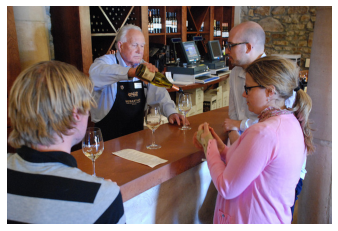

In [4]:
image_path = os.path.join(ROOT,image_dir, '000000000069.jpg')
image,np_image = preprocess_and_one_images(image_path)

print(np_image.shape)
# plot original image
plt.axis('off')
plt.imshow(image)
plt.show()

In [27]:
def preprocess_image(image):
    # Resize
    ratio = 800.0 / min(image.size[0], image.size[1])
    image = image.resize((int(ratio * image.size[0]), int(ratio * image.size[1])), Image.BILINEAR)

    # Convert to BGR
    image = np.array(image)[:, :, [2, 1, 0]].astype('float32')

    # HWC -> CHW
    image = np.transpose(image, [2, 0, 1])

    # Normalize
    mean_vec = np.array([102.9801, 115.9465, 122.7717])
    for i in range(image.shape[0]):
        image[i, :, :] = image[i, :, :] - mean_vec[i]

    # Pad to be divisible of 32
    import math
    padded_h = int(math.ceil(image.shape[1] / 32) * 32)
    padded_w = int(math.ceil(image.shape[2] / 32) * 32)

    padded_image = np.zeros((3, padded_h, padded_w), dtype=np.float32)
    padded_image[:, :image.shape[1], :image.shape[2]] = image
    image = padded_image

    return image

In [29]:
img = Image.open(image_path)
img_data = preprocess_image(img)

np_image
print(np_image.shape)
print(img_data.shape)

sess = rt.InferenceSession(model)

outputs = ['anchors',
           'box_classifier_features',
           'class_predictions_with_background',
           'detection_anchor_indices',
           'detection_boxes',
           'detection_classes',
           'detection_masks',
           'detection_multiclass_scores',
           'detection_scores',
           'final_anchors',
           'image_shape',
           'mask_predictions',
           'num_detections',
           'num_proposals',
           'proposal_boxes',
           'proposal_boxes_normalized',
           'raw_detection_boxes',
           'raw_detection_scores',
           'refined_box_encodings',
           'rpn_box_encodings',
           'rpn_box_predictor_features',
           'rpn_features_to_crop',
           'rpn_objectness_predictions_with_background'
          ]

results = sess.run(None,{'input_tensor:0':np_image})

(1, 640, 640, 3)
(3, 800, 1216)


In [30]:
(anchors,
 box_classifier_features,
 class_predictions_with_background,
 detection_anchor_indices,
 detection_boxes,
 detection_classes,
 detection_masks,
 detection_multiclass_scores,
 detection_scores,
 final_anchors,
 image_shape,
 mask_predictions,
 num_detections,
 num_proposals,
 proposal_boxes,
 proposal_boxes_normalized,
 raw_detection_boxes,
 raw_detection_scores,
 refined_box_encodings,
 rpn_box_encodings,
 rpn_box_predictor_features,
 rpn_features_to_crop,
 rpn_objectness_predictions_with_background) =results

In [31]:
print(num_detections)

[100.]


In [32]:
def preprocess_image(image):
    # Resize
    ratio = 800.0 / min(image.size[0], image.size[1])
    image = image.resize((int(ratio * image.size[0]), int(ratio * image.size[1])), Image.BILINEAR)

    # Convert to BGR
    image = np.array(image)[:, :, [2, 1, 0]].astype('float32')

    # HWC -> CHW
    image = np.transpose(image, [2, 0, 1])

    # Normalize
    mean_vec = np.array([102.9801, 115.9465, 122.7717])
    for i in range(image.shape[0]):
        image[i, :, :] = image[i, :, :] - mean_vec[i]

    # Pad to be divisible of 32
    import math
    padded_h = int(math.ceil(image.shape[1] / 32) * 32)
    padded_w = int(math.ceil(image.shape[2] / 32) * 32)

    padded_image = np.zeros((3, padded_h, padded_w), dtype=np.float32)
    padded_image[:, :image.shape[1], :image.shape[2]] = image
    image = padded_image

    return image

In [33]:
import matplotlib.patches as patches

import pycocotools.mask as mask_util
import cv2

def draw_detection(draw, boxe, score,classe, mask, score_threshold=0.7):
    #if score >= score_threshold: 
    """Draw box and label for 1 detection."""
    width, height = draw.im.size
    # the box is relative to the image size so we multiply with height and width to get pixels.
    top = boxe[0] * height
    left = boxe[1] * width
    bottom = boxe[2] * height
    right = boxe[3] * width    

    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(height, np.floor(bottom + 0.5).astype('int32'))
    right = min(width, np.floor(right + 0.5).astype('int32'))

    """ Draw mask"""
    int_boxe =[int(i) for i in boxe]
    mask = cv2.resize(mask, (int_boxe[2]-int_boxe[0]+1, int_boxe[3]-int_boxe[1]+1))
    mask = mask > 0.5

    im_mask = np.zeros((width, height), dtype=np.uint8)

    mask_y_0 = max(bottom - boxe[1], 0)
    mask_y_1 = mask_y_0 + right - bottom
    mask_x_0 = max(top - boxe[0], 0)
    mask_x_1 = mask_x_0 + left - top

    """
       im_mask[top:right, bottom:left] = mask[mask_y_0 : mask_y_1, mask_x_0 : mask_x_1]
        im_mask = im_mask[:, :, None]
    

    # OpenCV version 4.x
    contours, hierarchy = cv2.findContours(
        draw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
        )

    print(contours)
    draw = cv2.drawContours(draw, contours, -1, 25, 3)"""

    label = category_index[c]['name']
    label = label + ' '+ format(sc * 100, '.2f') +'%'
    label_size = draw.textsize(label)
    if top - label_size[1] >= 0:
        text_origin = tuple(np.array([left, top - label_size[1]]))
    else:
        text_origin = tuple(np.array([left, top + 1]))
    color = ImageColor.getrgb("red")
    thickness = 0
    draw.rectangle([left + thickness, top + thickness, right - thickness, bottom - thickness], outline=color)
    draw.text(text_origin, label, fill=color)  # , font=font)



In [75]:
def display_objdetect_image(image, boxes, labels, scores, masks, score_threshold=0.7):
    # Resize boxes
    ratio = 800.0 / min(image.size[0], image.size[1])
    boxes /= ratio

    _, ax = plt.subplots(1, figsize=(12,9))

    image = np.array(image)

    for mask, box, label, score in zip(masks, boxes, labels, scores):
        # Showing boxes with score > 0.7
        if score <= score_threshold:
            continue
        print(f"initial {mask[0]}")
        # Finding contour based on mask
        mask = mask[0, :, None]
        int_box = [int(i) for i in box]
        mask = cv2.resize(mask, (int_box[2]-int_box[0]+1, int_box[3]-int_box[1]+1))
        print(f"resize {mask[0]}")
        # mask = mask > 0.2
        print(f"condition {mask[0]}")
        im_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        print(f"im_mask: {im_mask}")
        print(f"box {box}")
        print(f"intbox {int_box}")
        x_0 = max(box[0], 0)
        x_1 = min(box[2] + 1, image.shape[1])
        y_0 = max(box[1], 0)
        y_1 = min(box[3] + 1, image.shape[0])
        print(f"print box x_0: {x_0} x_1: {x_1} y_0: {y_0} y_1: {y_1}")
        mask_y_0 = max(y_0 - box[1], 0)
        mask_y_1 = mask_y_0 + y_1 - y_0
        mask_x_0 = max(x_0 - box[0], 0)
        mask_x_1 = mask_x_0 + x_1 - x_0
        print(f"print box mask_y_0: {mask_y_0} mask_y_1: {mask_y_1} mask_x_0: {mask_x_0} mask_x_1: {mask_x_1}")
        im_mask[int(y_0):int(y_1), int(x_0):int(x_1)] = mask[
            int(mask_y_0) : int(mask_y_1), int(mask_x_0) : int(mask_x_1)
        ]
        print(f"after reframe mask {mask[int(mask_y_0) : int(mask_y_1), int(mask_x_0) : int(mask_x_1)]}")
        print(f"after reframe im_mask {im_mask[int(y_0):int(y_1), int(x_0):int(x_1)]}")
        im_mask = im_mask[:, :, None]
        print(f"im_mask[:, :, None] = {im_mask[int(y_0):int(y_1), int(x_0):int(x_1)]}")
        # OpenCV version 4.x
        contours, hierarchy = cv2.findContours(
            im_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
        )

        image = cv2.drawContours(image, contours, -1, 25, 3)

        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='b', facecolor='none')
        ax.annotate(category_index[label]['name'] + ':' + str(np.round(score, 2)), (box[0], box[1]), color='w', fontsize=12)
        ax.add_patch(rect)

    ax.imshow(image)
    plt.show()

In [76]:
#display_objdetect_image(image,detection_boxes,detection_classes,detection_scores,detection_masks)

initial [3.17335129e-04 6.28232956e-05 2.61962414e-05 2.14278698e-05
 1.96695328e-05 2.21133232e-05 2.79247761e-05 3.88920307e-05
 6.67870045e-05 1.65641308e-04 4.33802605e-04 1.38014555e-03
 4.73439693e-03 1.30097568e-02 4.06037271e-02 1.49507284e-01
 4.04591352e-01 6.43215418e-01 7.80539274e-01 8.52613330e-01
 8.99964929e-01 9.28680658e-01 9.44169283e-01 9.41568136e-01
 9.07818317e-01 7.84917116e-01 4.32630181e-01 1.15772694e-01
 1.54090524e-02 2.70023942e-03 7.25626945e-04 6.30944967e-04
 7.60436058e-04]
resize [0.40459135]
condition [0.40459135]
im_mask: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
box [3.9663970e-05 9.5251256e-05 1.6111923e-04 1.5263206e-04]
intbox [0, 0, 0, 0]
print box x_0: 3.9663969801040366e-05 x_1: 1.000161119227414 y_0: 9.525125642539933e-05 y_1: 1.0001526320556877
print box mask_y_0: 0.0 mask_y_1: 1.0000573807992623 mask_x_0: 0.0 mask_x_1: 1.000121455257613
after reframe mask [[0.404

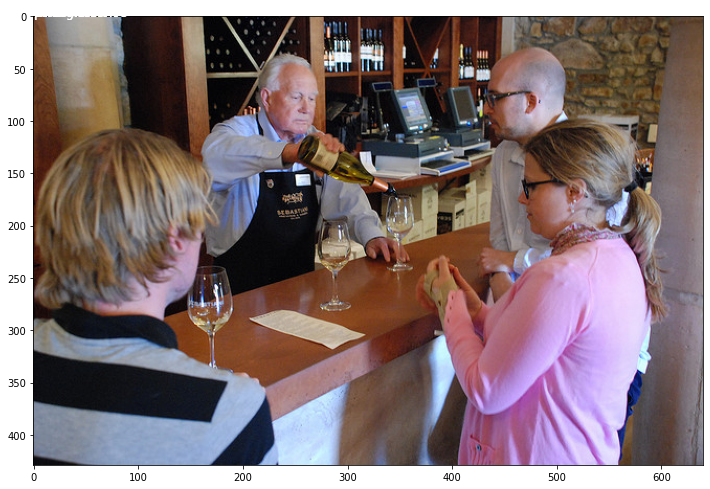

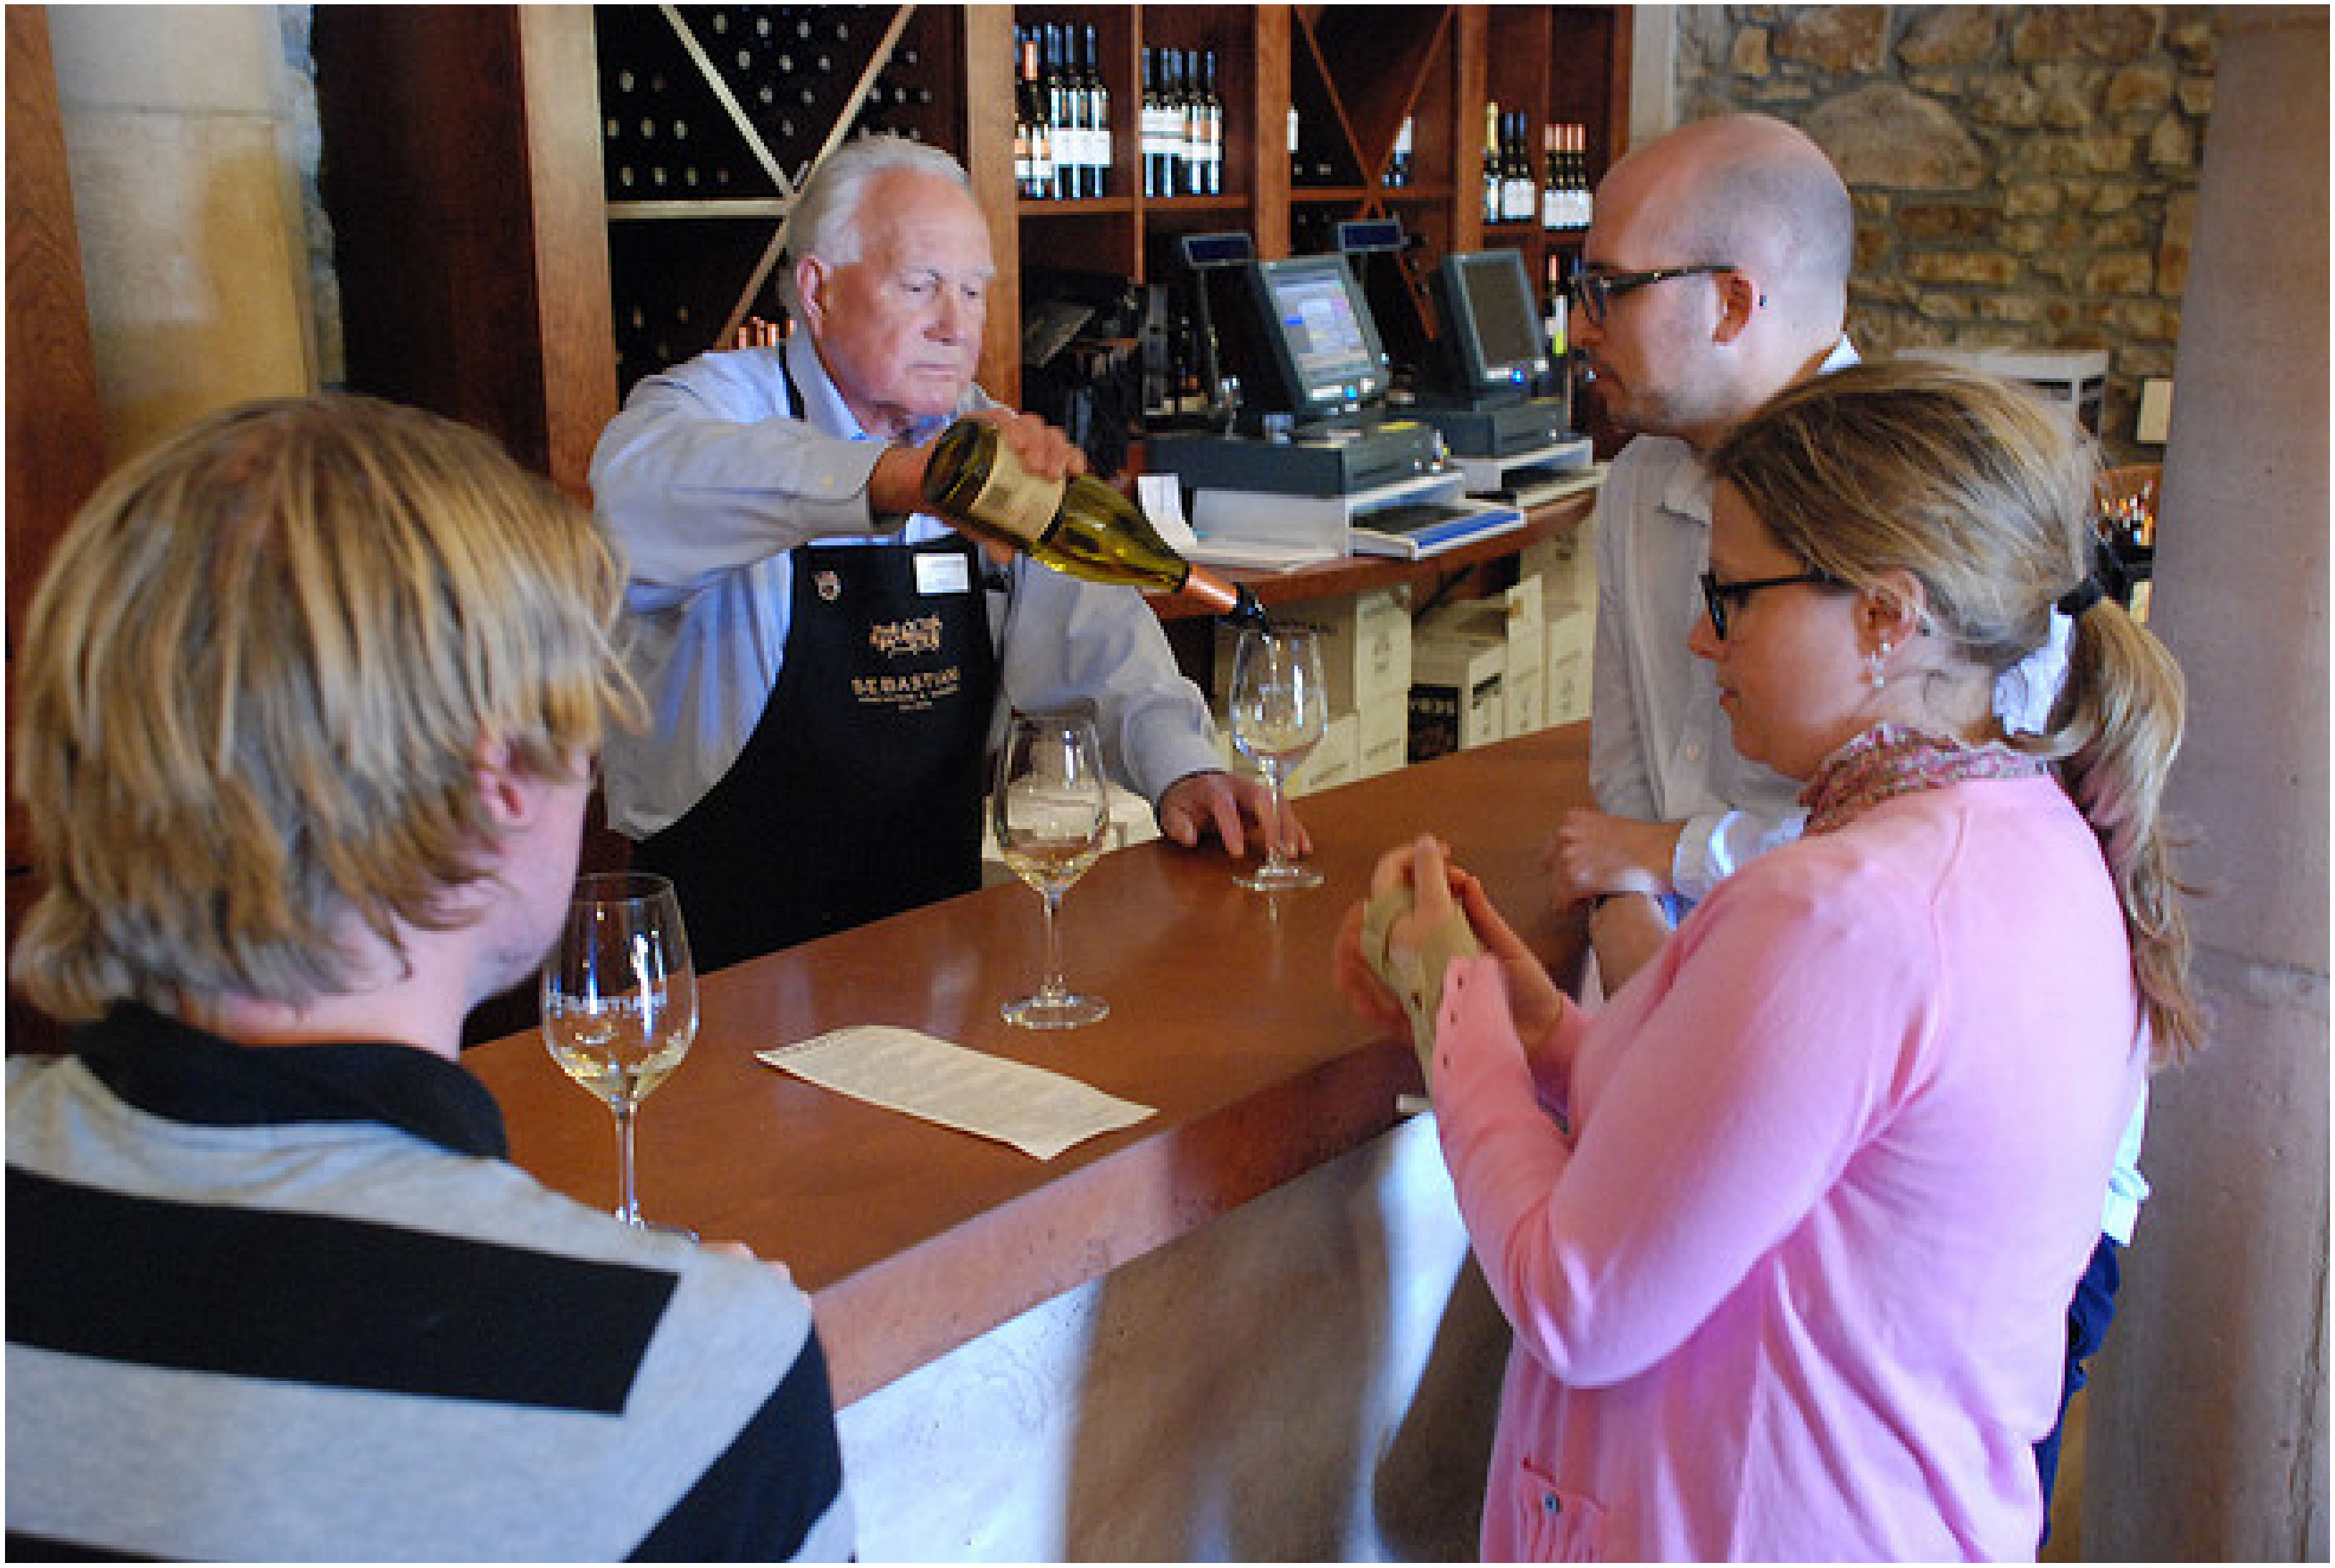

In [77]:
batch_size = num_detections.shape[0]
draw = ImageDraw.Draw(image)
for batch in range(0, batch_size):
    boxe = detection_boxes[batch]
    score = detection_scores[batch]
    classe = detection_classes[batch]
    mask = detection_masks[batch]
    display_objdetect_image(img,boxe,classe,score,mask)
#for detection in range(0, int(num_detections[batch])):
#draw_detection(draw, boxe, score,classe,mask)

plt.figure(figsize=(80, 40))
plt.axis('off')
plt.imshow(image)
plt.show()

## Evaluation process FPS and mAP

In [ ]:
image_dir = "images/val2017"
image_dir = os.path.join(ROOT,image_dir)

ann = "annotations/instances_val2017.json"
ann = os.path.join(ROOT,ann)


results_json = 'Mask_rcnn_test.json'
results_json = os.path.join(os.path.abspath(os.getcwd()),results_json)

In [ ]:
def preprocess_and_load_batch_images(path_to_dir, batch_size=32, image_size=[640,640]):
    image_list = []
    count = 0
    if os.path.exists(path_to_dir) and os.path.isdir(path_to_dir):
        for filename in glob.glob(path_to_dir + '/*.jpg'):
            _,np_image = preprocess_and_one_images(filename,image_size)
            
            image_list.append({'id':int(filename.split('.')[0].split('/')[-1]),
                               'np_img':np_image})
            count = count + 1
            if count == batch_size:
                count = 0
                yield image_list

In [ ]:
def get_detection(num_detections,detection_boxes,detection_classes,detection_scores):
    batch_size = num_detections.shape[0]
    for batch in range(0, batch_size):
        for detection in range(0, int(num_detections[batch])):
            c = detection_classes[batch][detection]
            b = detection_boxes[batch][detection]
            sc = detection_scores[batch][detection]
            yield (b,c,sc)

In [ ]:
def scalar_image(images_size,bbox):
    pass

In [ ]:
N_warmup_run=50
batch_size=32
image_size=[640,640]

results =[]
total_batch_time = []
total_image = 0

# delete results json file if exist
if os.path.exists(results_json):
    os.remove(results_json)

for batch in preprocess_and_load_batch_images(image_dir, batch_size=32, image_size=[640,640]):
    total_image = total_image + len(batch)
    for img in batch:
        start_time = time.time()
        ## apply model
        detections = sess.run(None,{'input_tensor:0':np_image})
        end_time = time.time()
        total_batch_time = np.append(total_batch_time, end_time-start_time)
        detection_anchor_indices, detection_boxes, detection_classes,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores = detections
        
        for elt in range(0, num_detections.shape[0]):
            for boxes,classes,score in get_detection(num_detections,detection_boxes,detection_classes,detection_scores):
                x = float(boxes[0])
                y = float(boxes[1])
                w = float(boxes[2]- boxes[0] + 1)
                h = float(boxes[3]- boxes[1] + 1)
                results.append({'image_id':img['id'],'category_id': int(classes),'bbox':[x, y, w, h],'score': float(score)})
        print(f"FPS in Batch {(total_batch_time[-len(batch):]).mean()} ms")
    
json.dump(results,open(results_json,'w'), indent = 4)
print(f" over all image FPS {total_image/(total_batch_time[-len(batch):]).sum()} ms")

cocoGt = COCO(ann)

cocoDt = cocoGt.loadRes(results_json)

imgIds = sorted(cocoGt.getImgIds())

cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')

cocoEval.params.imgIds = imgIds

cocoEval.evaluate()
cocoEval.accumulate()

print(cocoEval.summarize())
